# The game of Slap

This code simulates the game of Slap

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt

# Define the deck of cards
ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
attempt_map = {'J':1, 'Q':2, 'K':3, 'A':4}
faces = ['J', 'Q', 'K', 'A']
deck = [{'rank': rank, 'suit': suit} for rank in ranks for suit in suits]
pile = []
playing = []
hand = []

# various counters
current_turn = 0
challenge = False
attempts_remaining = 0
winner = None

def next(i):
    N = len(playing)
    for j in range(i+1,i+N):
        if playing[j % N]:
            return j % N
        
def prev(i):
    N = len(playing)
    for j in range(i-1,i-N,-1):
        if playing[j % N]:
            return j % N

# check for doubles (player 0 always loses the slap!)
def slap():
    global current_turn
    global challenge
    if len(pile) >= 2 and pile[-1]['rank'] == pile[-2]['rank']:
        i = random.randint(1, len(playing) - 1)
        # print(f"SLAP! Player {i} wins the pile!")
        hand[i].extend(pile)
        playing[i] = True
        pile.clear()
        current_turn = i
        challenge = False
        return True
    else:
        return False

# player i plays a card
def play_card(i):
    card = hand[i].pop(0)
    # print(f"Player {i} plays: {card['rank']} of {card['suit']}")
    pile.append(card)
    return card
        
# check to see if player i is out of cards, and whether the game is over or not.
def check_win(i):
    global winner
    global current_turn
    if not hand[i]:
        # print(f"Player {i} is out of cards, they're out for now")
        playing[i] = False
        
    # if only one player remaining, they win!
    if playing.count(True) == 1:
        winner = playing.index(True)
        # print(f"Player {winner} has won the game!")
        # print(playing)
        return True
    else:
        return False

def print_status():
    print( f"Currently player turn: {current_turn}" )
    print( f"Who is playing? {playing}" )
    for i in len(playing):
        print( f"Hand {i}: {[card['rank'] for card in hand[i]]}" )
    print( f"Pile: {[card['rank'] for card in pile]}" )
    print( f"Challenge? {challenge}" )
    

# Main game loop. Play a game with N players
def play_game(N):
    
    global current_turn 
    global challenge
    global attempts_remaining
    global playing
    
    # deal cards to N players (discard extras)
    random.shuffle(deck)
    cards_per_player = len(deck) // N
    hand.clear()
    for i in range(N):
        hand.append( deck[i * cards_per_player:(i + 1) * cards_per_player] )

    current_turn = random.randint(0,N-1)
    playing = [True] * N
    challenge = False
    attempts_remaining = 0
    
    for turn in range(100000):
                
        if not playing[current_turn]:
            print_status()
            
        card = play_card(current_turn)
                    
        if check_win(current_turn):
            break
        if slap():
            continue
            
        if challenge:
            if card['rank'] in faces:
                # challenger beat the challenge, passes on to next player
                attempts_remaining = attempt_map[card['rank']]
                # print(f"Player {current_turn} is challenging with a {card['rank']}, {attempts_remaining} attempts remaining.")
                current_turn = next(current_turn)
                continue
            else:
                attempts_remaining -= 1
                if attempts_remaining == 0:
                    # they did not beat the challenge, challenger takes the pile
                    i = prev(current_turn)
                    # print(f"Challenger (Player {i}) wins the challenge.")
                    hand[i].extend(pile)
                    playing[i] = True
                    pile.clear()
                    current_turn = i
                    challenge = False
                else:
                    # they just keep going. But if they're out of cards, the next person takes their place
                    if not playing[current_turn]:
                        current_turn = next(current_turn)
        else:
            if card['rank'] in faces:
                challenge = True
                attempts_remaining = attempt_map[card['rank']]
                # print(f"Player {current_turn} is challenging with a {card['rank']}, {attempts_remaining} attempts remaining.")
            
            current_turn = next(current_turn)
            continue
    return (winner, turn)

In [12]:
%%time

random.seed(1)

M = 100000 # 1000 = 0:45, 10000 = 7:41

expt = []
for N in range(2,14):    
    print(f"Currently on Experiment {N}")
    counts = [0] * N
    turns = []
    for _ in range(M):
        i,t = play_game(N)
        counts[i] += 1
        turns.append(t)
    expt.append( (N,M,counts,turns) )

Currently on Experiment 2
Currently on Experiment 3
Currently on Experiment 4
Currently on Experiment 5
Currently on Experiment 6
Currently on Experiment 7
Currently on Experiment 8
Currently on Experiment 9
Currently on Experiment 10
Currently on Experiment 11
Currently on Experiment 12
Currently on Experiment 13
CPU times: total: 1h 11min 9s
Wall time: 4h 40min 51s


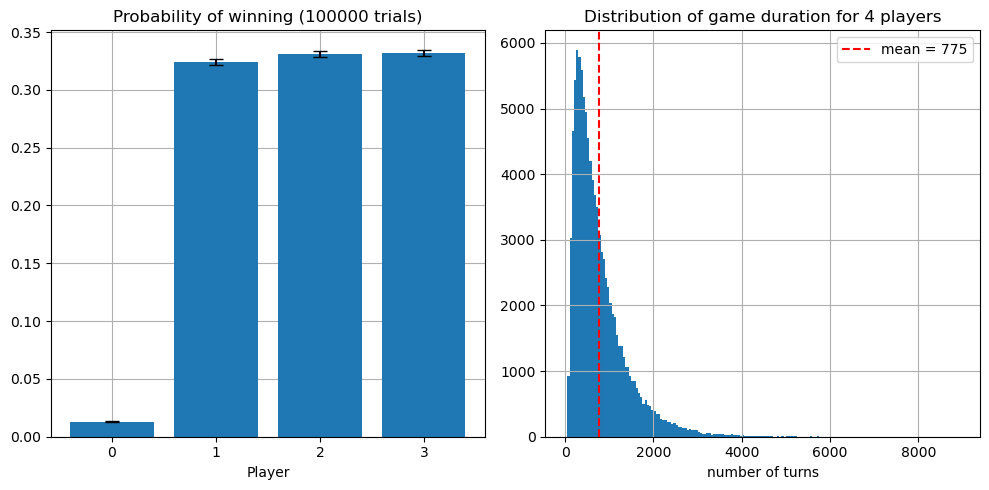

In [38]:
def plot_results(N,M,counts,turns):
    probs = np.array(counts) / M
    z = 1.96 # z-score for 95% confidence
    errors = [ z * np.sqrt(p * (1 - p) / M + z**2 / (4 * M**2)) for p in probs ]
    m = np.mean(turns)
    # print(m)
    # print(probs)
    # print(errors)
    
    fig,axs = plt.subplots(1,2, figsize=(10,5))
    
    plt.sca(axs[0])
    plt.bar(range(N), probs, yerr=errors, capsize=5, zorder=2)
    plt.xticks(range(N))
    plt.title(f"Probability of winning ({M} trials)")
    plt.xlabel("Player")
    plt.grid(zorder = 1)
    
    plt.sca(axs[1])
    plt.hist(turns,range(0,np.max(turns),50),density=False)
    plt.axvline(x=m, color='red', linestyle='--', label=f'mean = {m:.0f}')
    plt.grid()
    plt.title(f"Distribution of game duration for {N} players")
    plt.xlabel("number of turns")
    plt.legend()
    
    fig.tight_layout()
    return fig
    
fig = plot_results(*expt[4 - 2])
# fig.savefig('slap13.png')

1
2
3
4
5
6
7
8
9
10
11
12


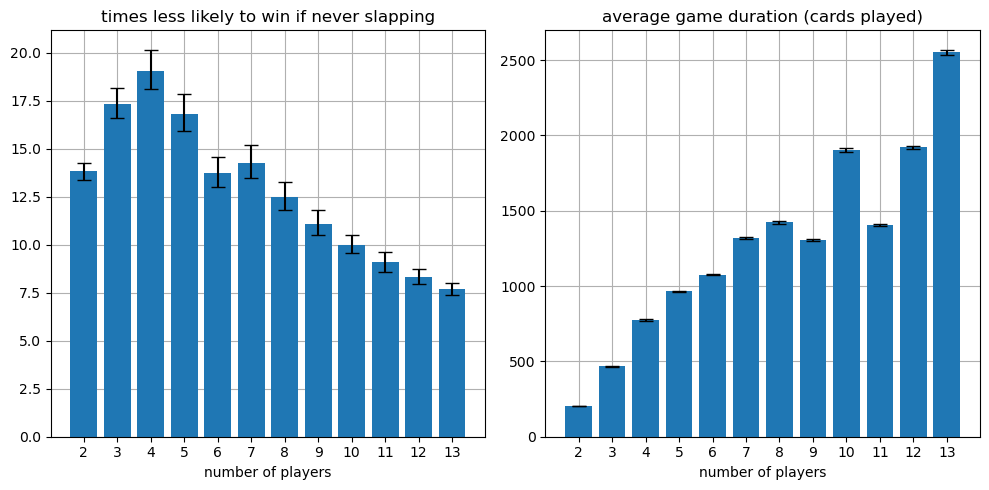

In [37]:
nx = [] # number of players
px = [] # empirical probability of winning for player 0
ex = [] # confidence interval for px
dx = [] # mean number of turns in a game
sx1 = [] # lower error for dx (bootstrap)
sx2 = [] # upper error for dx (bootstrap)

q = 0
for (N,M,counts,turns) in expt:
    q += 1
    print(q)
    nx.append( N )
    p = counts[0] / M
    z = 1.96
    px.append( np.maximum(p,1e-2) )
    ex.append( z * np.sqrt(p * (1 - p) / M + z**2 / (4 * M**2)) )
    dx.append( np.mean(turns) )
    
    
    # Number of bootstrap samples
    num_bootstraps = 1000

    # Create an array to store sample means
    bootstrap_means = np.zeros(num_bootstraps)

    # Perform bootstrapping
    for i in range(num_bootstraps):
        # Resample with replacement
        bootstrap_sample = np.random.choice(turns, size=M, replace=True)

        # Calculate the mean for the bootstrap sample
        bootstrap_means[i] = np.mean(bootstrap_sample)

    # Calculate the confidence interval
    confidence_interval = np.percentile(bootstrap_means, [2.5, 97.5])
    
    sx1.append( np.mean(turns) - confidence_interval[0] )
    sx2.append( confidence_interval[1] - np.mean(turns) )
    
    
    
rx = [1/nx[i]/px[i] for i in range(len(nx))]
erlo = [1/nx[i]/px[i] - 1/nx[i]/(px[i]+ex[i]) for i in range(len(nx))]
erhi = [1/nx[i]/(px[i]-ex[i]) - 1/nx[i]/px[i] for i in range(len(nx))]

fig,axs = plt.subplots(1,2, figsize=(10,5))

plt.sca(axs[0])
plt.bar(nx, rx, yerr=[erlo,erhi], capsize=5, zorder=2)
plt.xticks(nx)
plt.grid(zorder=1)
plt.xlabel("number of players")
plt.title("times less likely to win if never slapping")

plt.sca(axs[1])
plt.bar(nx, dx, yerr=[sx1,sx2], capsize=5, zorder=2)
plt.xticks(nx)
plt.grid(zorder=1)
plt.xlabel("number of players")
plt.title("average game duration (cards played)")

fig.tight_layout()

fig.savefig("slapx.png")

In [113]:
[(N, 52//N) for N in range(2,14)]

[(2, 26),
 (3, 17),
 (4, 13),
 (5, 10),
 (6, 8),
 (7, 7),
 (8, 6),
 (9, 5),
 (10, 5),
 (11, 4),
 (12, 4),
 (13, 4)]